# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Read Wind Energy Production Dataset

In [193]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_production_dataset.csv')

data.head()

,Country,Date,Value,Wind10int,Wind100int
0,Australia,2023-03-01,2415.8842,3.689722,5.550105
1,Australia,2023-02-01,2540.7584,3.966472,5.909515
2,Australia,2023-01-01,2614.8241,4.017246,5.866050
3,Australia,2022-12-01,2690.1965,4.128255,6.038626
4,Australia,2022-11-01,2510.9518,4.213749,6.209358


## Extract Data for each country

In [194]:
countries = data['Country'].unique()

wind_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'wind' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Wind10int', 'Wind100int']
    ]
    
    # Store the filtered data in the dictionary
    wind_production_data[country] = country_energy_production.reset_index(drop=True)

wind_production_data['United States']

,Date,Value,Wind10int,Wind100int
0,2023-03-01,44426.3310,3.762072,5.986961
1,2023-02-01,42084.0444,3.756134,6.122668
2,2023-01-01,39139.6361,3.420258,5.655555
3,2022-12-01,39343.8760,3.595494,5.906426
4,2022-11-01,42035.8654,3.587919,5.837720
...,...,...,...,...
154,2010-05-01,8681.7900,3.479868,5.401551
155,2010-04-01,9838.5130,3.758076,5.942071
156,2010-03-01,8683.1880,3.503326,5.649119
157,2010-02-01,5494.1570,3.170092,5.072068


# Model Building

In [4]:
import matplotlib.pyplot as plt

## United States Wind Energy Generation

In [156]:
data = wind_production_data['United States']

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()

print(data.head())
print(data.shape)

               Value  Wind10int  Wind100int
Date                                       
2010-01-01  6964.964   3.459058    5.613944
2010-02-01  5494.157   3.170092    5.072068
2010-03-01  8683.188   3.503326    5.649119
2010-04-01  9838.513   3.758076    5.942071
2010-05-01  8681.790   3.479868    5.401551
(159, 3)


### Split train and test data

In [116]:
# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

               Value  Wind10int  Wind100int
Date                                       
2010-01-01  6964.964   3.459058    5.613944
2010-02-01  5494.157   3.170092    5.072068
2010-03-01  8683.188   3.503326    5.649119
2010-04-01  9838.513   3.758076    5.942071
2010-05-01  8681.790   3.479868    5.401551
(133, 3)

                 Value  Wind10int  Wind100int
Date                                         
2021-01-01  30479.1127   3.374649    5.565576
2021-02-01  26726.5226   3.533872    5.709729
2021-03-01  39627.0266   3.770230    6.040676
2021-04-01  35969.5158   3.558406    5.592598
2021-05-01  33254.9815   3.366446    5.224574
(27, 3)


## Univariate Model - ARIMA - Monthly

In [7]:
from statsmodels.tsa.arima.model import ARIMA

The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,0,1)(0,1,1)[12] 

Figure below show the result from R:
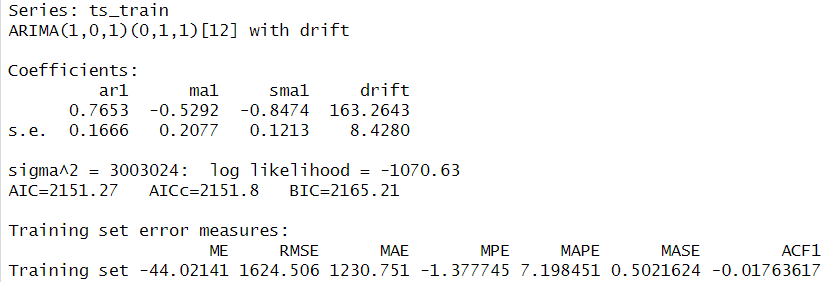

In [117]:
# Create the ARIMA model with the specified order
us_monthly_arima = ARIMA(train['Value'].values, order=(1,0,1), seasonal_order=(0,1,1,12))
# Fit the model to the training data
us_monthly_arima = us_monthly_arima.fit()
print(us_monthly_arima.summary())

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  133
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1083.910
Date:                          Wed, 26 Jul 2023   AIC                           2175.820
Time:                                  08:55:51   BIC                           2187.003
Sample:                                       0   HQIC                          2180.362
                                          - 133                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9957      0.003    350.373      0.000       0.990       1.001
ma.L1         -0.8300      0.046    -18.140      0.

In [118]:
# Generate predictions
predictions = us_monthly_arima.predict(start=len(train), end=len(train) + len(test) - 1)

# Evaluate the model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

print("Mean Absolute Error: ", mean_absolute_error(predictions, test['Value'].values))
mse = mean_squared_error(predictions, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  4878.142955967614
Mean Squared Error:  33635512.97319585
Root Mean Squared Error:  5799.613174444987


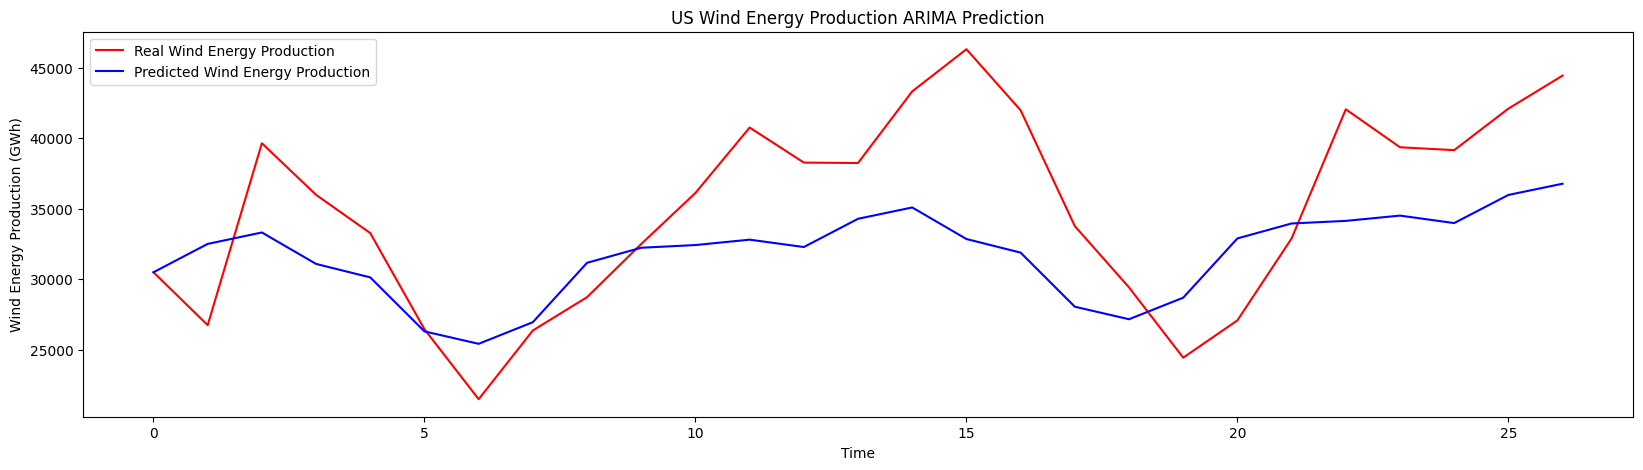

In [119]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [11]:
def create_features(df, label=None):

    #Creates time series features from datetime index

    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['quarter','month','year',
           'dayofyear','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            quarter  month  year  dayofyear  weekofyear
Date                                                   
2010-01-01        1      1  2010          1          53
2010-02-01        1      2  2010         32           5
2010-03-01        1      3  2010         60           9
2010-04-01        2      4  2010         91          13
2010-05-01        2      5  2010        121          17
(133, 5)

Date
2010-01-01    6964.964
2010-02-01    5494.157
2010-03-01    8683.188
2010-04-01    9838.513
2010-05-01    8681.790
Name: Value, dtype: float64
(133,)

            quarter  month  year  dayofyear  weekofyear
Date                                                   
2021-01-01        1      1  2021          1          53
2021-02-01        1      2  2021         32           5
2021-03-01        1      3  2021         60           9
2021-04-01        2      4  2021         91          13
2021-05-01        2      5  2021        121          17
(27, 5)

Date
2021-01-01    30479.1127
2021-02-01 

In [13]:
# pip install xgboost

In [14]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [15]:
us_monthly_xgb = xgb.XGBRegressor(n_estimators=1000)
us_monthly_xgb.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_test, y_test)],
                   early_stopping_rounds=50,
                   verbose=True) 

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:13404.25923	validation_1-rmse:28790.84620
[1]	validation_0-rmse:9735.35678	validation_1-rmse:23835.87145
[2]	validation_0-rmse:7186.62823	validation_1-rmse:20134.42983
[3]	validation_0-rmse:5351.91181	validation_1-rmse:17266.26757
[4]	validation_0-rmse:4037.32646	validation_1-rmse:14892.11130
[5]	validation_0-rmse:3137.90811	validation_1-rmse:13236.34672
[6]	validation_0-rmse:2462.76054	validation_1-rmse:11987.36473
[7]	validation_0-rmse:1960.87604	validation_1-rmse:11002.75010
[8]	validation_0-rmse:1607.08562	validation_1-rmse:10289.46373
[9]	validation_0-rmse:1339.34216	validation_1-rmse:9753.27288
[10]	validation_0-rmse:1132.19827	validation_1-rmse:9447.65192
[11]	validation_0-rmse:985.22653	validation_1-rmse:9218.78293
[12]	validation_0-rmse:857.55018	validation_1-rmse:9043.14000
[13]	validation_0-rmse:778.43946	validation_1-rmse:8840.27173
[14]	validation_0-rmse:729.62817	validation_1-rmse:8689.48030
[15]	validation_0-rmse:648.80825	validation_1-rmse:8614.680

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

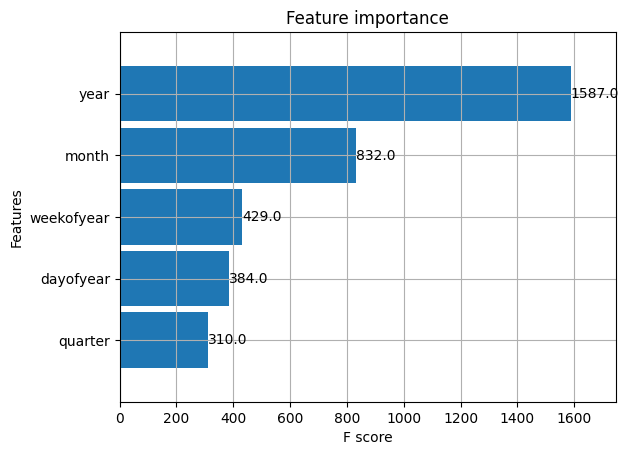

In [16]:
_ = plot_importance(us_monthly_xgb, height=0.9)

In [17]:
predictions = us_monthly_xgb.predict(X_test)

In [18]:
print("Mean Absolute Error: ", mean_absolute_error(predictions, test['Value'].values))
mse = mean_squared_error(predictions, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  6978.353860879632
Mean Squared Error:  68872805.36303483
Root Mean Squared Error:  8298.9641138539


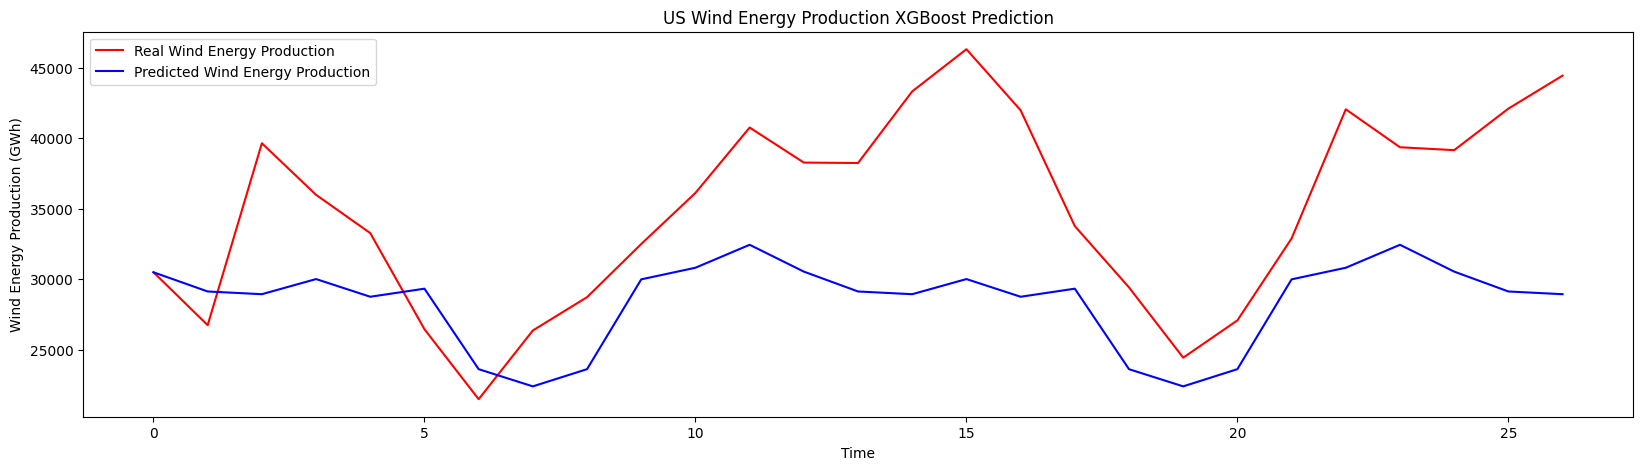

In [19]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [20]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 12  # Define the number of previous time steps to consider

# Creating a data structure with 12 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(121, 12) (121,)


In [22]:
# Build and Train the SVM Model
us_monthly_svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05) # Specify desired hyperparameters
us_monthly_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [23]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Solar Energy Production
y_pred = us_monthly_svr.predict(x_test).reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred.shape)

(27, 1)


In [24]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(y_pred, test['Value'].values))
mse = mean_squared_error(y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  8856.835032061217
Mean Squared Error:  124629718.07768852
Root Mean Squared Error:  11163.768094943953


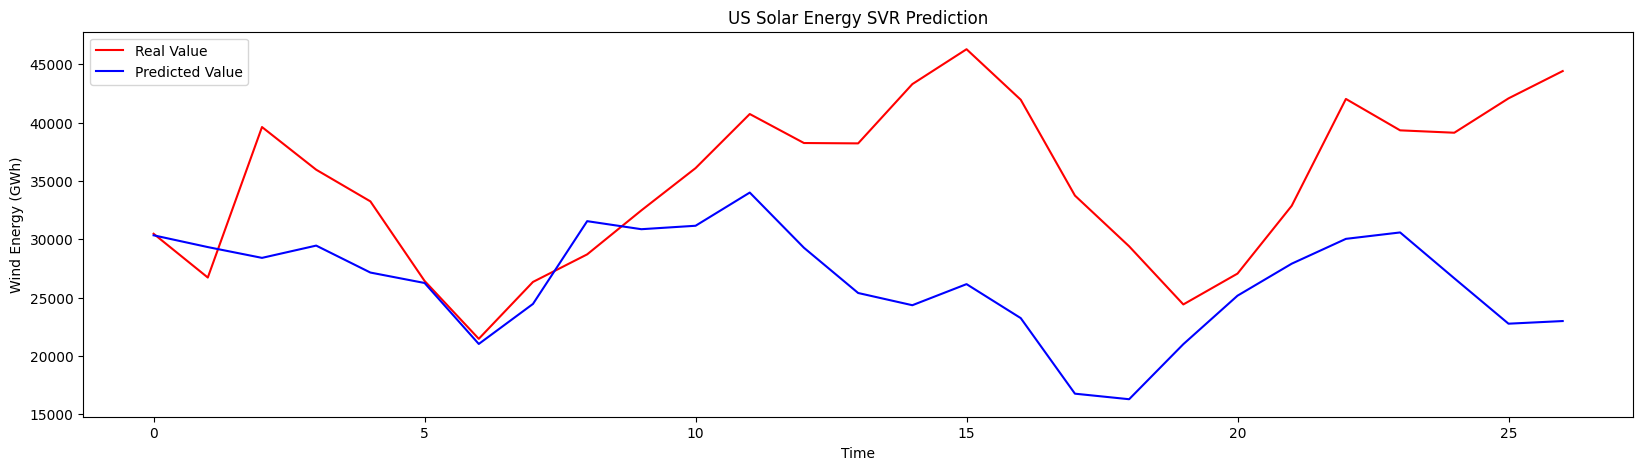

In [25]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(y_pred, color='blue', label='Predicted Value')
plt.title('US Solar Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Monthly

In [26]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [27]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 12

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [28]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
us_monthly_gru = Sequential()
us_monthly_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
us_monthly_gru.add(GRU(units=64))
us_monthly_gru.add(Dense(1, activation='linear'))

us_monthly_gru.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
us_monthly_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 56s 79ms/step - loss: 0.0683
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 0.0255
Epoch 3/100
4/4 [==============================] - 0s 139ms/step - loss: 0.0250
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0165
Epoch 5/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0205
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0153
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0146
Epoch 8/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0159
Epoch 9/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0139
Epoch 10/100
4/4 [==============================] - 0s 103ms/step - loss: 0.0139
Epoch 11/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0137
Epoch 12/100
4/4 [==============================] - 0s 115ms/step - loss: 0.0129
Epoch 13/100
4/4 [===========================

In [30]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

predicted_value = us_monthly_gru.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)

1/1 [==============================] - 9s 9s/step


In [31]:
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, test['Value'].values))
mse = mean_squared_error(predicted_value, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3933.4719434027784
Mean Squared Error:  25334888.232960373
Root Mean Squared Error:  5033.377418092187


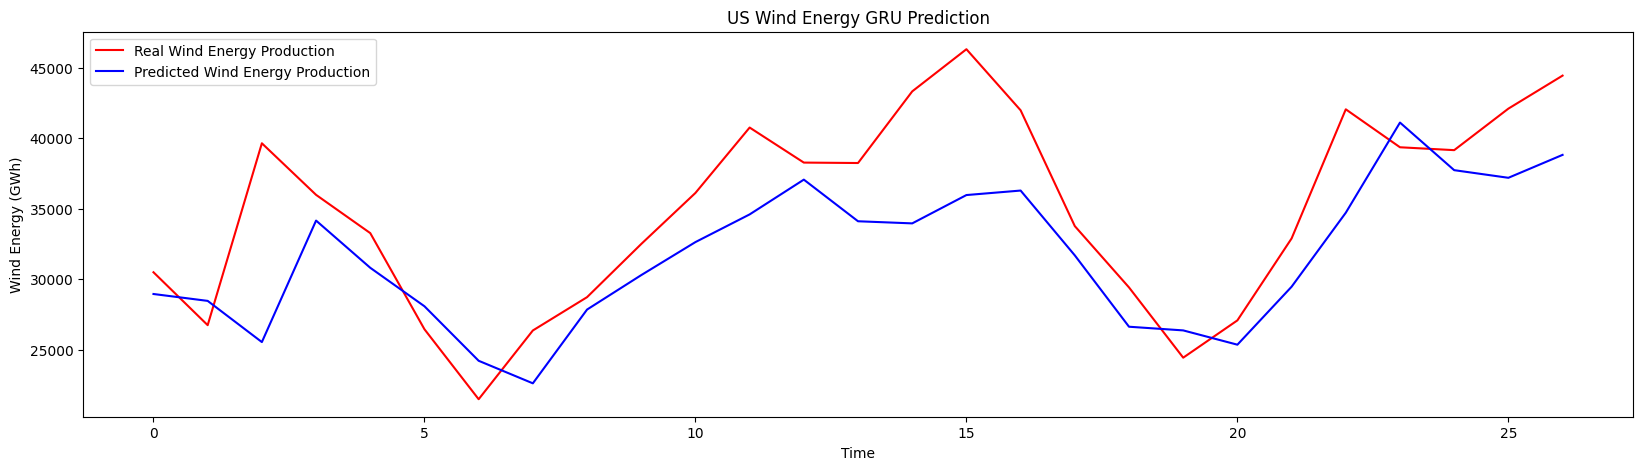

In [32]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predicted_value, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Monthly

In [33]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)
print(training_set_scaled.shape)

(133, 1)


In [34]:
# Creating a data structure with 12 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [35]:
print(X_train.shape)
print(y_train.shape)

(121, 12)
(121,)


In [36]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [37]:
# Building the RNN(LSTM)

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [38]:
# Initialising the RNN
us_monthly_uni_lstm = Sequential()

# Adding the first LSTM layer
us_monthly_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))

us_monthly_uni_lstm.add(LSTM(units = 64, return_sequences = True))

us_monthly_uni_lstm.add(LSTM(units = 64))

# Adding the output layer
us_monthly_uni_lstm.add(Dense(units = 1))

In [39]:
# Compiling the RNN
us_monthly_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
us_monthly_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
4/4 [==============================] - 71s 136ms/step - loss: 0.1747
Epoch 2/100
4/4 [==============================] - 1s 168ms/step - loss: 0.0355
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0419
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0194
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0265
Epoch 6/100
4/4 [==============================] - 0s 84ms/step - loss: 0.0188
Epoch 7/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0164
Epoch 8/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0161
Epoch 9/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0145
Epoch 10/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0145
Epoch 11/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0126
Epoch 12/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0135
Epoch 13/100
4/4 [============================

In [40]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_value = us_monthly_uni_lstm.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)

1/1 [==============================] - 16s 16s/step


In [41]:
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, test['Value'].values))
mse = mean_squared_error(predicted_value, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4752.642146180555
Mean Squared Error:  31372258.7711014
Root Mean Squared Error:  5601.094426190421


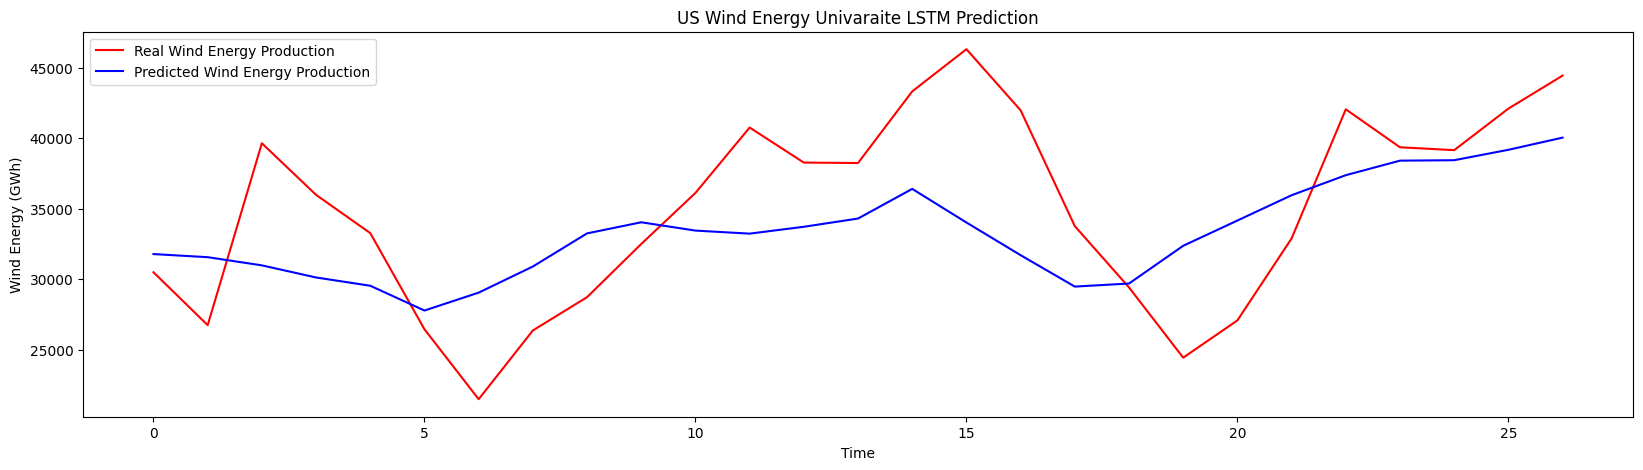

In [42]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predicted_value, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy Univaraite LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [43]:
data = wind_production_data['United States']

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()

data.shape

(159, 3)

In [44]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2010-01-01,3.459058,5.613944,6964.964
2010-02-01,3.170092,5.072068,5494.157
2010-03-01,3.503326,5.649119,8683.188
2010-04-01,3.758076,5.942071,9838.513
2010-05-01,3.479868,5.401551,8681.790


In [45]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(133, 3)
(27, 3)

(133, 1)
(27, 1)


In [46]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [47]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 12  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 12 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

(121, 12, 3)


In [48]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

us_monthly_multi_lstm = Sequential()
us_monthly_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
us_monthly_multi_lstm.add(LSTM(units = 64, return_sequences = True))
us_monthly_multi_lstm.add(LSTM(units = 64))
us_monthly_multi_lstm.add(Dense(1))

us_monthly_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
us_monthly_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 86s 44ms/step - loss: 0.1682
Epoch 2/100
4/4 [==============================] - 0s 124ms/step - loss: 0.0427
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0433
Epoch 4/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0379
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0301
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0209
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 8/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0137
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0118
Epoch 10/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0123
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0113
Epoch 12/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0110
Epoch 13/100
4/4 [=============================

In [50]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 12:]
inputs = X_scaler.transform(inputs)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
predicted_value = us_monthly_multi_lstm.predict(X_test1)
predicted_value = y_scaler.inverse_transform(predicted_value)
real_value = y_scaler.inverse_transform(y_test)

1/1 [==============================] - 14s 14s/step


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, real_value))
mse = mean_squared_error(predicted_value, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3551.9023590277775
Mean Squared Error:  20251094.489750132
Root Mean Squared Error:  4500.121608329061


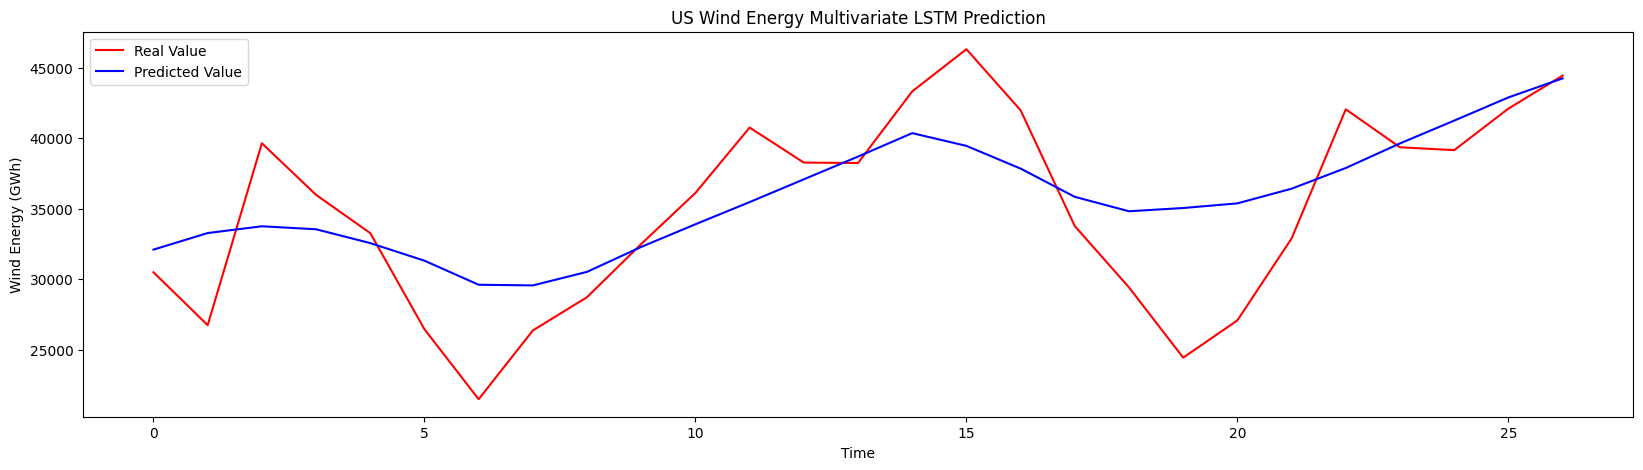

In [52]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(predicted_value, color='blue', label='Predicted Value')
plt.title('US Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Resample to daily data

In [195]:
# hypro_production_data
for country_data in wind_production_data:
    
    # set time as the index
    wind_production_data[country_data]['Date'] = pd.to_datetime(wind_production_data[country_data]['Date'])
    wind_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    wind_production_data[country_data]['Value'] = (wind_production_data[country_data]['Value']/
                                                    wind_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = wind_production_data[country_data].resample('D').interpolate('linear')
    wind_production_data[country_data] = daily_data
    
wind_production_data['United States']

,Value,Wind10int,Wind100int
Date,,,
2010-01-01,224.676258,3.459058,5.613944
2010-01-02,223.758311,3.449736,5.596465
2010-01-03,222.840364,3.440415,5.578985
2010-01-04,221.922416,3.431093,5.561505
2010-01-05,221.004469,3.421772,5.544025
...,...,...,...
2023-02-25,1443.092328,3.761224,6.006348
2023-02-26,1440.596109,3.761436,6.001501
2023-02-27,1438.099890,3.761648,5.996654


In [196]:
wind_daily_production_data = {}

for country in wind_production_data:
    wind_daily_production_data[country] = wind_production_data[country].copy()
    wind_daily_production_data[country] = wind_daily_production_data[country].reset_index()
    wind_daily_production_data[country]['Country'] = country
    wind_daily_production_data[country] = wind_daily_production_data[country][['Country'] + list(wind_daily_production_data[country].columns[:-1])]
    
# Concatenate the datasets into a single DataFrame
wind_dataset = pd.concat(wind_daily_production_data.values())
# Reset the index of the concatenated DataFrame
wind_dataset.reset_index(drop=True, inplace=True)

# Save the concatenated DataFrame to a CSV file
wind_dataset.to_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_daily_production_dataset.csv', index=False)

# Model Building

### Split train and test data

In [159]:
data = wind_production_data['United States']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                 Value
Date                  
2010-01-01  224.676258
2010-01-02  223.758311
2010-01-03  222.840364
2010-01-04  221.922416
2010-01-05  221.004469
(4019, 1)

                 Value
Date                  
2021-01-01  983.197184
2021-01-02  982.272070
2021-01-03  981.346957
2021-01-04  980.421843
2021-01-05  979.496730
(790, 1)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,0)(0,1,0)[365] 

#### Figure below show the result from R:
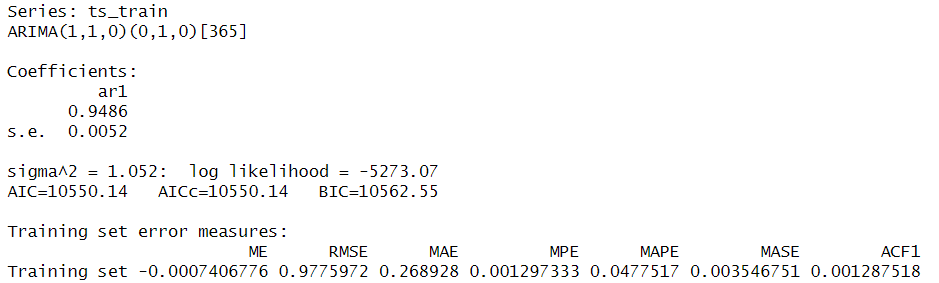

In [120]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
us_wind_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\us_wind_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: This is forecast 8.21 
  Want to stay up-to-date? Read the Hyndsight blog:
  https://robjhyndman.com/hyndsight/

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [125]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(us_wind_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test.values))
mse = mean_squared_error(predictions.rx('mean')[0], test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  217.74522789377562
Mean Squared Error:  67218.49288433735
Root Mean Squared Error:  259.2652944077501


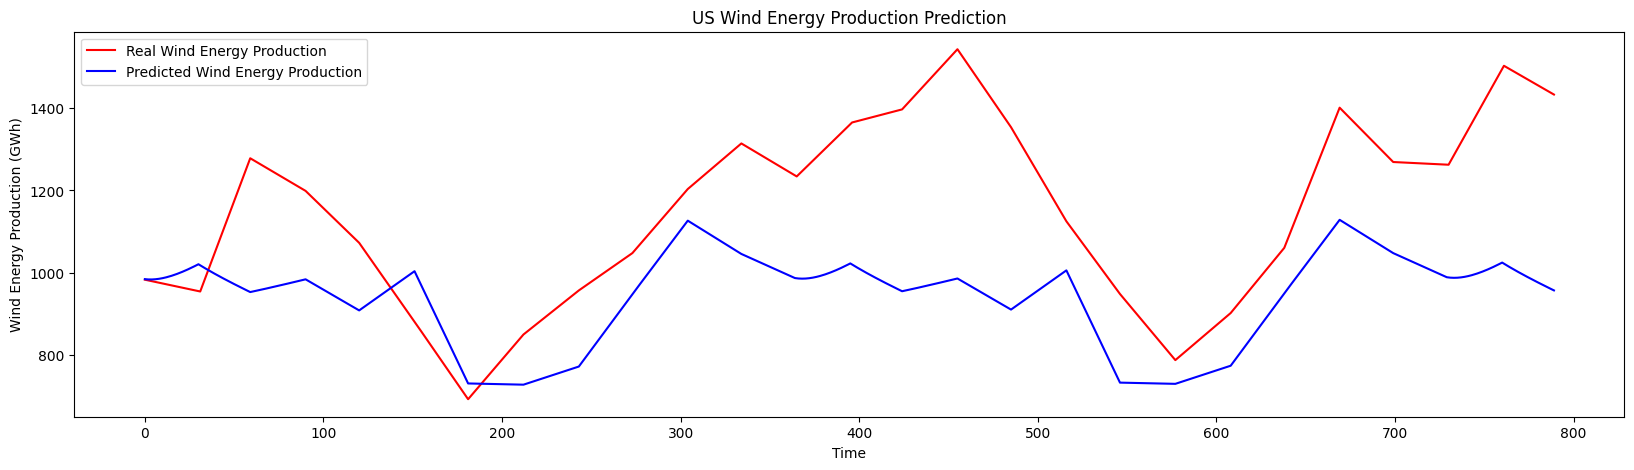

In [126]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [133]:
def create_features(df, label=None):

    #Creates time series features from datetime index
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [134]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2010-01-01          4        1      1  2010          1           1          53
2010-01-02          5        1      1  2010          2           2          53
2010-01-03          6        1      1  2010          3           3          53
2010-01-04          0        1      1  2010          4           4           1
2010-01-05          1        1      1  2010          5           5           1
(4019, 7)

Date
2010-01-01    224.676258
2010-01-02    223.758311
2010-01-03    222.840364
2010-01-04    221.922416
2010-01-05    221.004469
Freq: D, Name: Value, dtype: float64
(4019,)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2021-01-01          4        1      1  2021          1           1          53
2021-01-02          5  

In [61]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [62]:
us_daily_xgb = xgb.XGBRegressor(n_estimators=1000)
us_daily_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:429.75499	validation_1-rmse:891.02526
[1]	validation_0-rmse:302.85491	validation_1-rmse:699.75937
[2]	validation_0-rmse:213.88256	validation_1-rmse:567.37001
[3]	validation_0-rmse:151.40964	validation_1-rmse:475.05231
[4]	validation_0-rmse:107.59611	validation_1-rmse:411.26373
[5]	validation_0-rmse:77.11157	validation_1-rmse:368.65197
[6]	validation_0-rmse:55.91616	validation_1-rmse:338.61022
[7]	validation_0-rmse:41.17545	validation_1-rmse:317.16416
[8]	validation_0-rmse:31.19942	validation_1-rmse:302.50867
[9]	validation_0-rmse:24.25757	validation_1-rmse:292.27594
[10]	validation_0-rmse:19.88052	validation_1-rmse:284.87792
[11]	validation_0-rmse:17.00495	validation_1-rmse:279.73508
[12]	validation_0-rmse:14.85574	validation_1-rmse:276.14509
[13]	validation_0-rmse:13.61333	validation_1-rmse:273.63828
[14]	validation_0-rmse:12.86409	validation_1-rmse:271.71948
[15]	validation_0-rmse:11.87882	validation_1-rmse:270.47609
[16]	validation_0-rmse:11.02235	validation_1-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

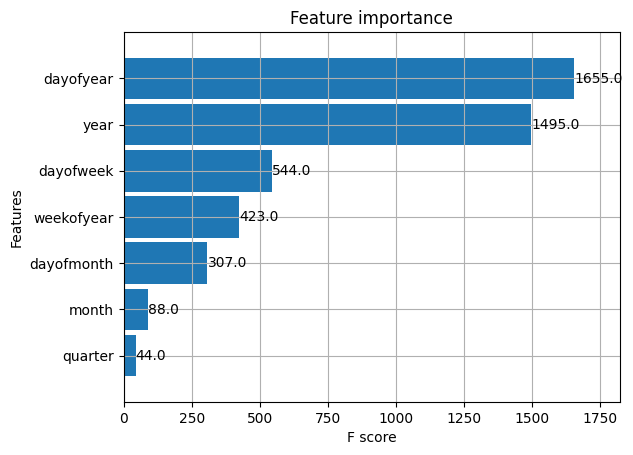

In [63]:
_ = plot_importance(us_daily_xgb, height=0.9)

In [135]:
xgb_y_pred = us_daily_xgb.predict(X_test)

In [136]:
print("Mean Absolute Error: ", mean_absolute_error(xgb_y_pred, test['Value'].values))
mse = mean_squared_error(xgb_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  225.58869930665554
Mean Squared Error:  71582.84426424946
Root Mean Squared Error:  267.5497042873519


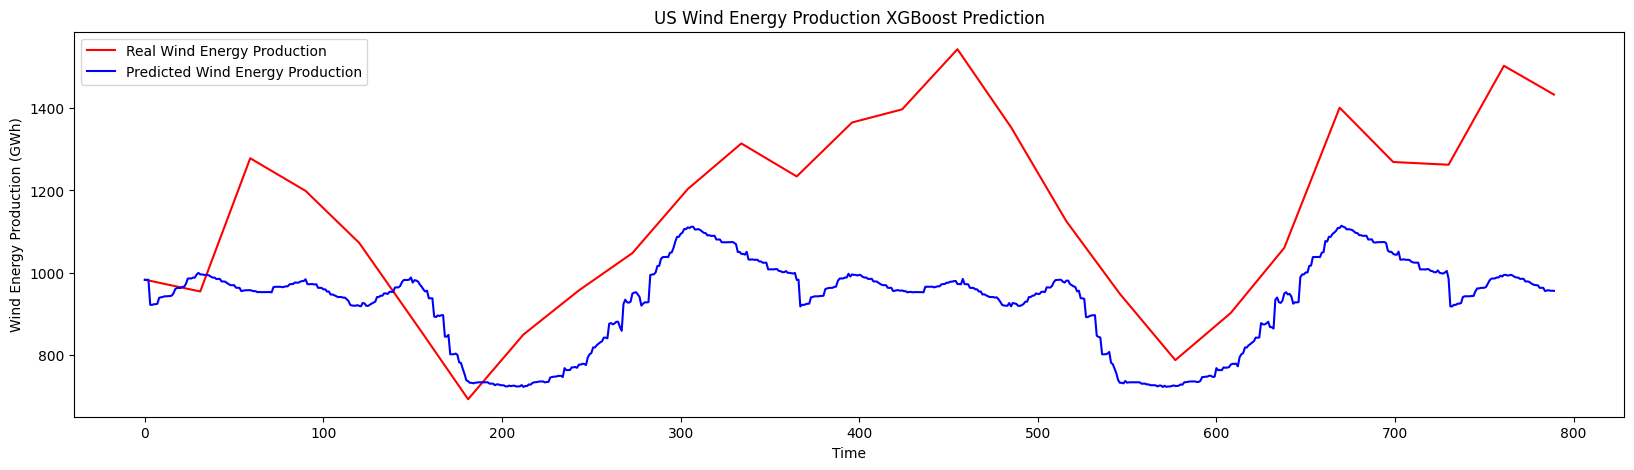

In [137]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(xgb_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [67]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [138]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [69]:
# Build and Train the SVM Model
us_daily_svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05) # Specify hyperparameters
us_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [139]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Wind Energy Production
svr_y_pred = us_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [140]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  454.0413814596447
Mean Squared Error:  255416.49476538753
Root Mean Squared Error:  505.3874699331074


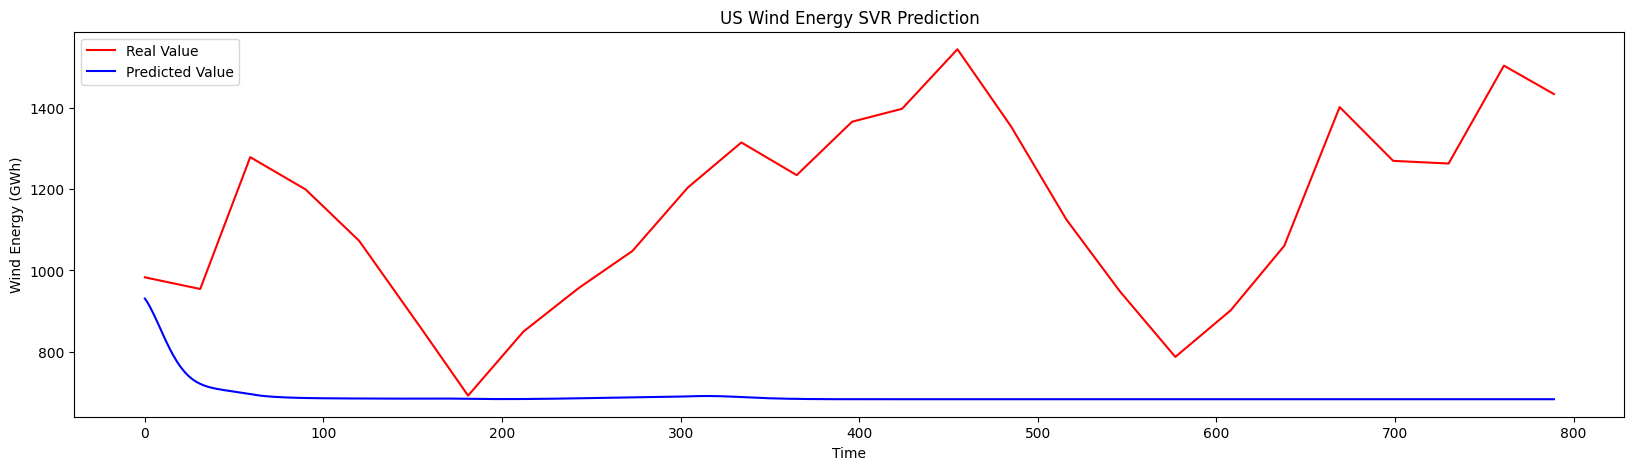

In [141]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('US Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [185]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [186]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [187]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
us_daily_gru = Sequential()
us_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
us_daily_gru.add(GRU(units=64))
us_daily_gru.add(Dense(1, activation='linear'))

us_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [188]:
us_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 45s 196ms/step - loss: 0.0105
Epoch 2/100
115/115 [==============================] - 24s 204ms/step - loss: 8.6160e-05
Epoch 3/100
115/115 [==============================] - 26s 223ms/step - loss: 6.8585e-05
Epoch 4/100
115/115 [==============================] - 24s 212ms/step - loss: 5.5547e-05
Epoch 5/100
115/115 [==============================] - 28s 242ms/step - loss: 4.6760e-05
Epoch 6/100
115/115 [==============================] - 24s 206ms/step - loss: 3.9853e-05
Epoch 7/100
115/115 [==============================] - 22s 192ms/step - loss: 3.5891e-05
Epoch 8/100
115/115 [==============================] - 23s 197ms/step - loss: 3.1714e-05
Epoch 9/100
115/115 [==============================] - 23s 197ms/step - loss: 2.5352e-05
Epoch 10/100
115/115 [==============================] - 22s 188ms/step - loss: 2.0733e-05
Epoch 11/100
115/115 [==============================] - 21s 183ms/step - loss: 1.5150e-05
Epoch 12/100
115/115 [=

In [189]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = us_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 19s 67ms/step


In [190]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  7.005436541964154
Mean Squared Error:  51.93907175935544
Root Mean Squared Error:  7.206876699330678


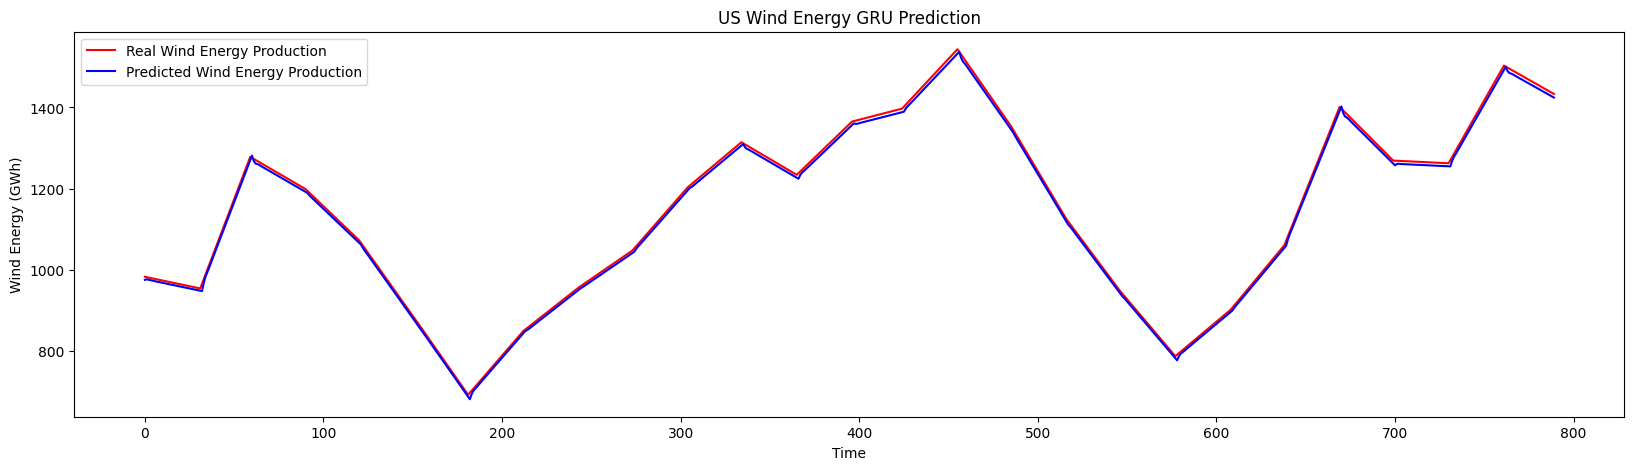

In [191]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [166]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.03065056]
 [0.02966183]
 [0.0286731 ]
 ...
 [0.8518669 ]
 [0.84976295]
 [0.84765901]]
(4019, 1)


In [167]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [168]:
print(X_train)
X_train.shape

[[0.03065056 0.02966183 0.0286731  ... 0.0910763  0.0909161  0.09075589]
 [0.02966183 0.0286731  0.02768438 ... 0.0909161  0.09075589 0.09059568]
 [0.0286731  0.02768438 0.02669565 ... 0.09075589 0.09059568 0.09396723]
 ...
 [0.77033442 0.77230577 0.77549699 ... 0.85817874 0.85607479 0.85397085]
 [0.77230577 0.77549699 0.77868822 ... 0.85607479 0.85397085 0.8518669 ]
 [0.77549699 0.77868822 0.78187945 ... 0.85397085 0.8518669  0.84976295]]


(3654, 365)

In [169]:
print(y_train)
y_train.shape

[0.09059568 0.09396723 0.09733879 ... 0.8518669  0.84976295 0.84765901]


(3654,)

In [170]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [85]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [86]:
# Initialising the RNN
us_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
us_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
us_daily_uni_lstm.add(Dropout(0.2))

us_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
us_daily_uni_lstm.add(Dropout(0.2))

us_daily_uni_lstm.add(LSTM(units = 64))
us_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
us_daily_uni_lstm.add(Dense(units = 1))

In [87]:
# Compiling the RNN
us_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
us_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 247s 1s/step - loss: 0.0109
Epoch 2/100
115/115 [==============================] - 143s 1s/step - loss: 0.0026
Epoch 3/100
115/115 [==============================] - 146s 1s/step - loss: 0.0024
Epoch 4/100
115/115 [==============================] - 141s 1s/step - loss: 0.0018
Epoch 5/100
115/115 [==============================] - 145s 1s/step - loss: 0.0019
Epoch 6/100
115/115 [==============================] - 145s 1s/step - loss: 0.0017
Epoch 7/100
115/115 [==============================] - 145s 1s/step - loss: 0.0014
Epoch 8/100
115/115 [==============================] - 143s 1s/step - loss: 0.0014
Epoch 9/100
115/115 [==============================] - 139s 1s/step - loss: 0.0013
Epoch 10/100
115/115 [==============================] - 142s 1s/step - loss: 0.0012
Epoch 11/100
115/115 [==============================] - 143s 1s/step - loss: 0.0012
Epoch 12/100
115/115 [==============================] - 142s 1s/step - loss: 0.0012
E

Epoch 94/100
115/115 [==============================] - 76s 663ms/step - loss: 3.4120e-04
Epoch 95/100
115/115 [==============================] - 72s 629ms/step - loss: 3.4720e-04
Epoch 96/100
115/115 [==============================] - 76s 666ms/step - loss: 3.3106e-04
Epoch 97/100
115/115 [==============================] - 74s 641ms/step - loss: 3.5891e-04
Epoch 98/100
115/115 [==============================] - 75s 650ms/step - loss: 3.3686e-04
Epoch 99/100
115/115 [==============================] - 70s 607ms/step - loss: 3.2014e-04
Epoch 100/100
115/115 [==============================] - 69s 605ms/step - loss: 3.4612e-04


In [88]:
test[['Value']].shape

(790, 1)

In [171]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = us_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 6s 87ms/step


In [172]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  54.28683686984719
Mean Squared Error:  4081.452066757043
Root Mean Squared Error:  63.88624317297929


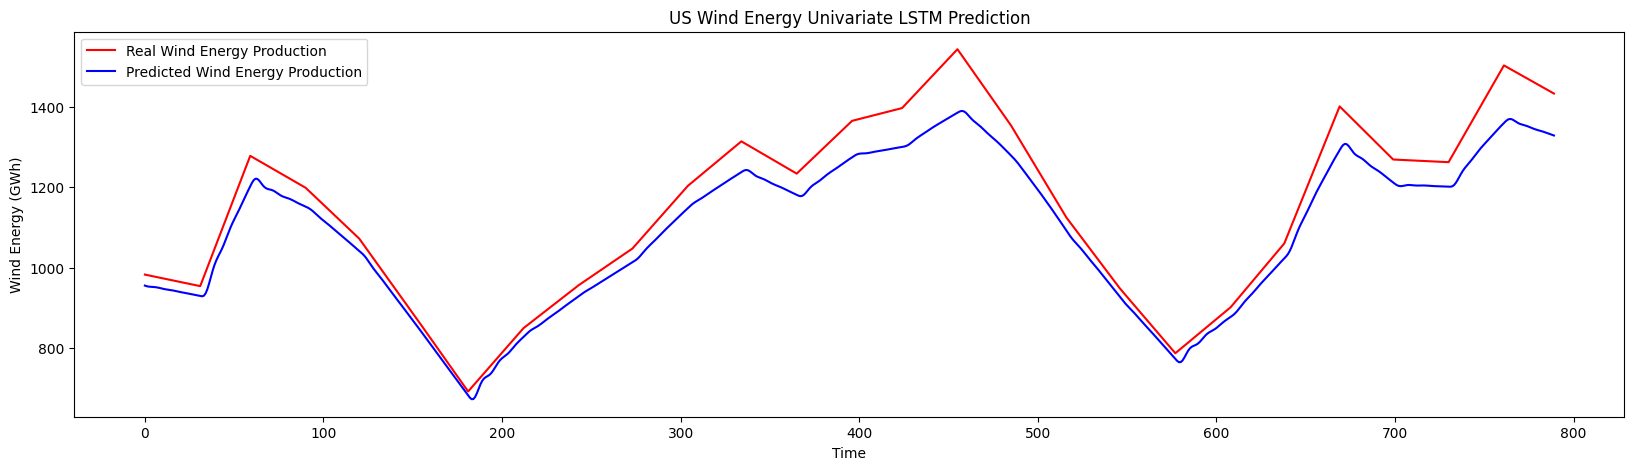

In [173]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('US Wind Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [174]:
data = wind_production_data['United States']

data.shape

(4808, 3)

In [175]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2010-01-01,3.459058,5.613944,224.676258
2010-01-02,3.449736,5.596465,223.758311
2010-01-03,3.440415,5.578985,222.840364
2010-01-04,3.431093,5.561505,221.922416
2010-01-05,3.421772,5.544025,221.004469


In [176]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [177]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [178]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 3)
(790, 3)

(4019, 1)
(790, 1)


In [179]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(3654, 365, 3)


In [180]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [101]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

us_daily_multi_lstm = Sequential()
us_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
us_daily_multi_lstm.add(Dropout(0.2))
us_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
us_daily_multi_lstm.add(Dropout(0.2))
us_daily_multi_lstm.add(LSTM(units = 64))
us_daily_multi_lstm.add(Dropout(0.2))
us_daily_multi_lstm.add(Dense(1))

In [102]:
us_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

us_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 124s 614ms/step - loss: 0.0104
Epoch 2/100
115/115 [==============================] - 77s 667ms/step - loss: 0.0027
Epoch 3/100
115/115 [==============================] - 92s 798ms/step - loss: 0.0021
Epoch 4/100
115/115 [==============================] - 102s 890ms/step - loss: 0.0022
Epoch 5/100
115/115 [==============================] - 116s 1s/step - loss: 0.0017
Epoch 6/100
115/115 [==============================] - 108s 940ms/step - loss: 0.0018
Epoch 7/100
115/115 [==============================] - 116s 1s/step - loss: 0.0016
Epoch 8/100
115/115 [==============================] - 114s 994ms/step - loss: 0.0014
Epoch 9/100
115/115 [==============================] - 112s 972ms/step - loss: 0.0014
Epoch 10/100
115/115 [==============================] - 114s 994ms/step - loss: 0.0013
Epoch 11/100
115/115 [==============================] - 121s 1s/step - loss: 0.0012
Epoch 12/100
115/115 [==============================] - 133s 1s

In [181]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
multi_lstm_y_pred = us_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 3)
25/25 [==============================] - 6s 93ms/step


array([[ 968.3373 ],
       [ 966.61896],
       [ 965.15717],
       [ 964.19104],
       [ 963.76154],
       [ 963.7256 ],
       [ 963.83966],
       [ 963.8566 ],
       [ 963.5981 ],
       [ 962.98914],
       [ 962.05505],
       [ 960.8913 ],
       [ 959.62036],
       [ 958.3525 ],
       [ 957.15784],
       [ 956.0588 ],
       [ 955.03674],
       [ 954.0504 ],
       [ 953.05524],
       [ 952.0192 ],
       [ 950.9318 ],
       [ 949.8029 ],
       [ 948.6568 ],
       [ 947.5226 ],
       [ 946.4285 ],
       [ 945.39276],
       [ 944.4182 ],
       [ 943.49664],
       [ 942.6132 ],
       [ 941.7524 ],
       [ 940.90076],
       [ 940.0501 ],
       [ 939.19666],
       [ 939.7193 ],
       [ 943.2476 ],
       [ 950.5358 ],
       [ 961.7259 ],
       [ 975.8931 ],
       [ 991.6335 ],
       [1007.5958 ],
       [1022.7903 ],
       [1036.5691 ],
       [1049.059  ],
       [1060.4547 ],
       [1071.0239 ],
       [1080.985  ],
       [1090.4696 ],
       [1099.

In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  125.33766061267747
Mean Squared Error:  41920.38271168653
Root Mean Squared Error:  204.7446768824199


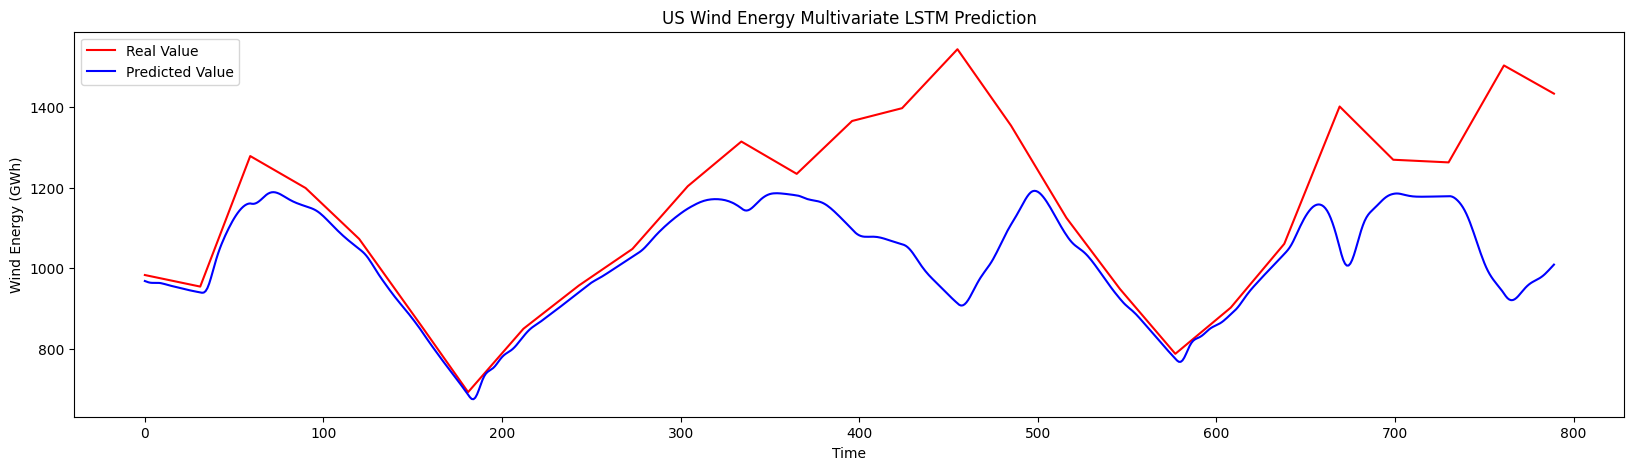

In [183]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('US Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Discussion:
Based on the finding above, it can show that the model train with daily data are out perform than using monthly data for all the models build.
Therefore, in the folling models build for other countries, the developer will use the daily data to build the time series models.

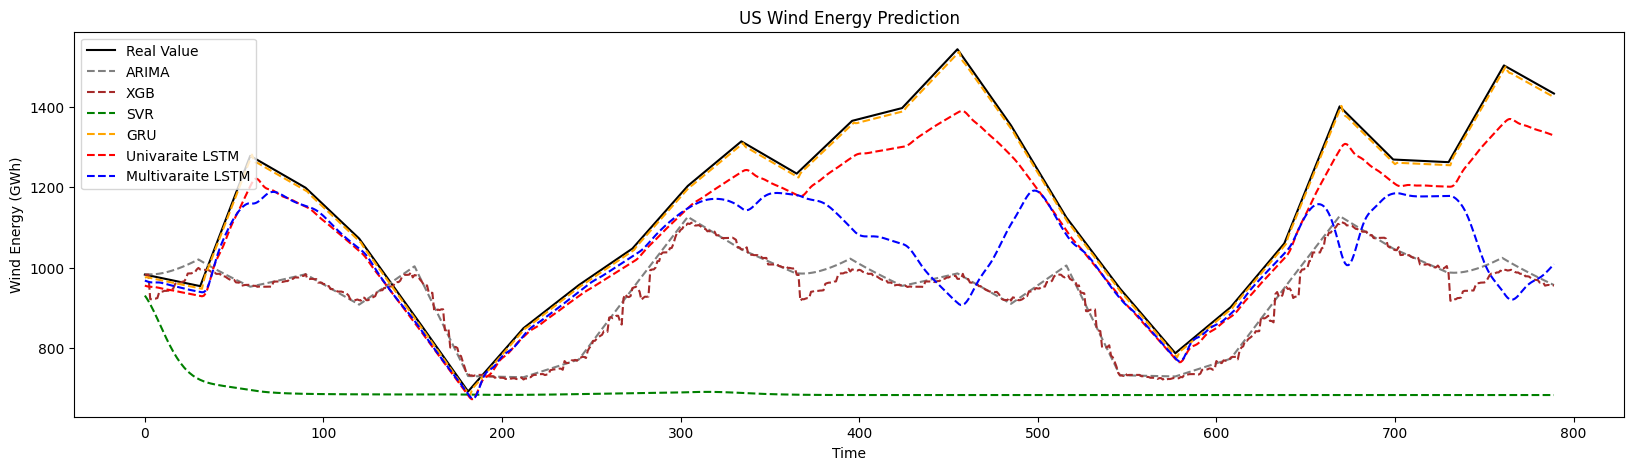

In [192]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(xgb_y_pred, color='brown', linestyle='--', label='XGB')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('US Wind Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Tuning

In [127]:
data = wind_production_data['United States']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)


dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

(3654, 365) (3654,)


In [128]:
# SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Define the hyperparameter grid to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
}

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with SVR model, hyperparameter grid, and TimeSeriesSplit
grid_search = GridSearchCV(estimator=us_daily_svr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)

# Perform the grid search to find the best hyperparameters
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(C=10, epsilon=0.05, gamma=0.5),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=1)

In [129]:
# Get the best hyperparameters and best model
svr_best_params = grid_search.best_params_
svr_best_model = grid_search.best_estimator_

print(svr_best_params)
print(svr_best_model)

{'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')


In [130]:
# Train the best model on the full training set
svr_best_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = svr_best_model.predict(x_test).reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(y_pred, test['Value'].values))
mse = mean_squared_error(y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  6.919830619958224
Mean Squared Error:  70.99799894593623
Root Mean Squared Error:  8.426031031626707


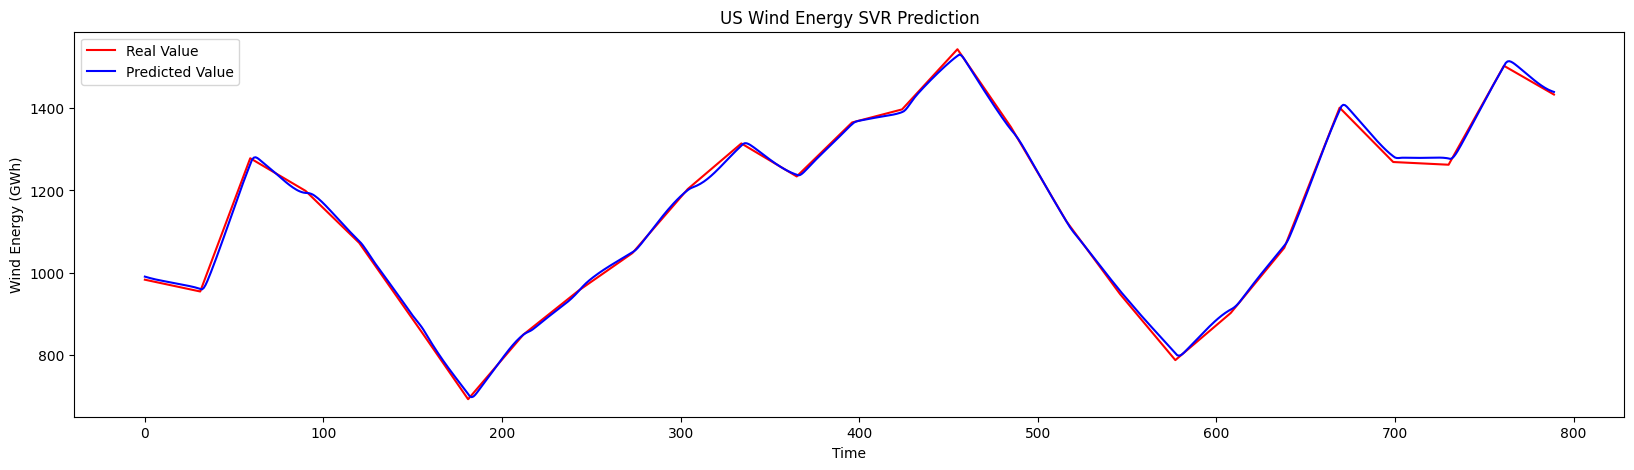

In [131]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(y_pred, color='blue', label='Predicted Value')
plt.title('US Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [106]:
us_daily_gru.save("us_wind_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
